In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from google.colab import drive, files
drive.mount('/content/drive')
rootpath = '/content/drive/Shareddrives/KW phase1 repo'

Mounted at /content/drive


In [2]:
import sys
sys.path.append(rootpath+'/package')
from utils.env_sdp_realRSS import env
import pickle
import numpy as np
import csv

from model.uav import UAV, setUAVEnv
from model.realData_indoor_sdpv3 import calculateSDP, setSDPEnv
from model.pathlossmodel import PathLossModel, NoiseMaker, setPathLossModelEnv

from service.distributeuavs import createUAVsSamples,setDistributeUavsEnv , TestEnv
from service.measurerss import measureRSS, setMeasuerRssEnv
from service.combinationset import combinationSet , setCombinationSetEnv
from multiprocessing import Pool

setDistributeUavsEnv("sdp_realRSS")
TestEnv()
setCombinationSetEnv("sdp_realRSS")
setPathLossModelEnv("sdp_realRSS")
setMeasuerRssEnv("sdp_realRSS")
setUAVEnv("sdp_realRSS")
setSDPEnv("sdp_realRSS")

envName sdp_realRSS
11


In [3]:
ESPNames = [ "ESP01", "ESP02", "ESP03", "ESP04", "ESP05", "ESP06", "ESP07", "ESP08", "ESP09", "ESP10", "ESP11" ]

In [4]:
savePath = '/content/drive/Shareddrives/KW phase1 repo/datas/anomalySDPResult/0906_realRSS_10-26'
# !mkdir /content/drive/Shareddrives/KW\ phase1\ repo/datas/anomalySDPResult
!mkdir /content/drive/Shareddrives/KW\ phase1\ repo/datas/anomalySDPResult/0906_realRSS_10-26

mkdir: cannot create directory ‘/content/drive/Shareddrives/KW phase1 repo/datas/anomalySDPResult/0906_realRSS_10-26’: File exists


In [5]:
# rssFolder = "/rssMeasurements_0827_outdoor"
# rssFolder = "/rssMeasurements_0827_indoor"
rssFolder = "/rssMeasurements_0828_indoor"
# envPlace = "Outdoor"
envPlace = "Indoor"

if envPlace == "Outdoor":
  # Outdoor Coordinates
  espPositions_cm = {
      "ESP01": [0, 0, 53],
      "ESP02": [180, 0, 29],
      "ESP03": [360, 0, 87],
      "ESP04": [270, 90, 18],
      "ESP05": [0, 180, 27],
      "ESP06": [180, 180, 59],
      "ESP07": [360, 180, 28],
      "ESP08": [90, 270, 29],
      "ESP09": [0, 360, 96],
      "ESP10": [180, 360, 25],
      "ESP11": [360, 360, 59]
  }
elif envPlace == "Indoor":
  # Indoor Coordinates
  espPositions_cm = {
      "ESP01": [0, 115+95, 154],
      "ESP02": [0, 95, 28],
      "ESP03": [0, 0, 154],
      "ESP04": [76, 95-45, 65],
      "ESP05": [76+114, 95, 27],
      "ESP06": [163, 0, 154],
      "ESP07": [76+114+90, 95, 28],
      "ESP08": [76+114+90+72, 95+54, 60],
      "ESP09": [176+163, 0, 154],
      "ESP10": [76+114+90+72+86, 95, 23],
      "ESP11": [163+176+113, 0, 154]
  }

### Indoor ENV
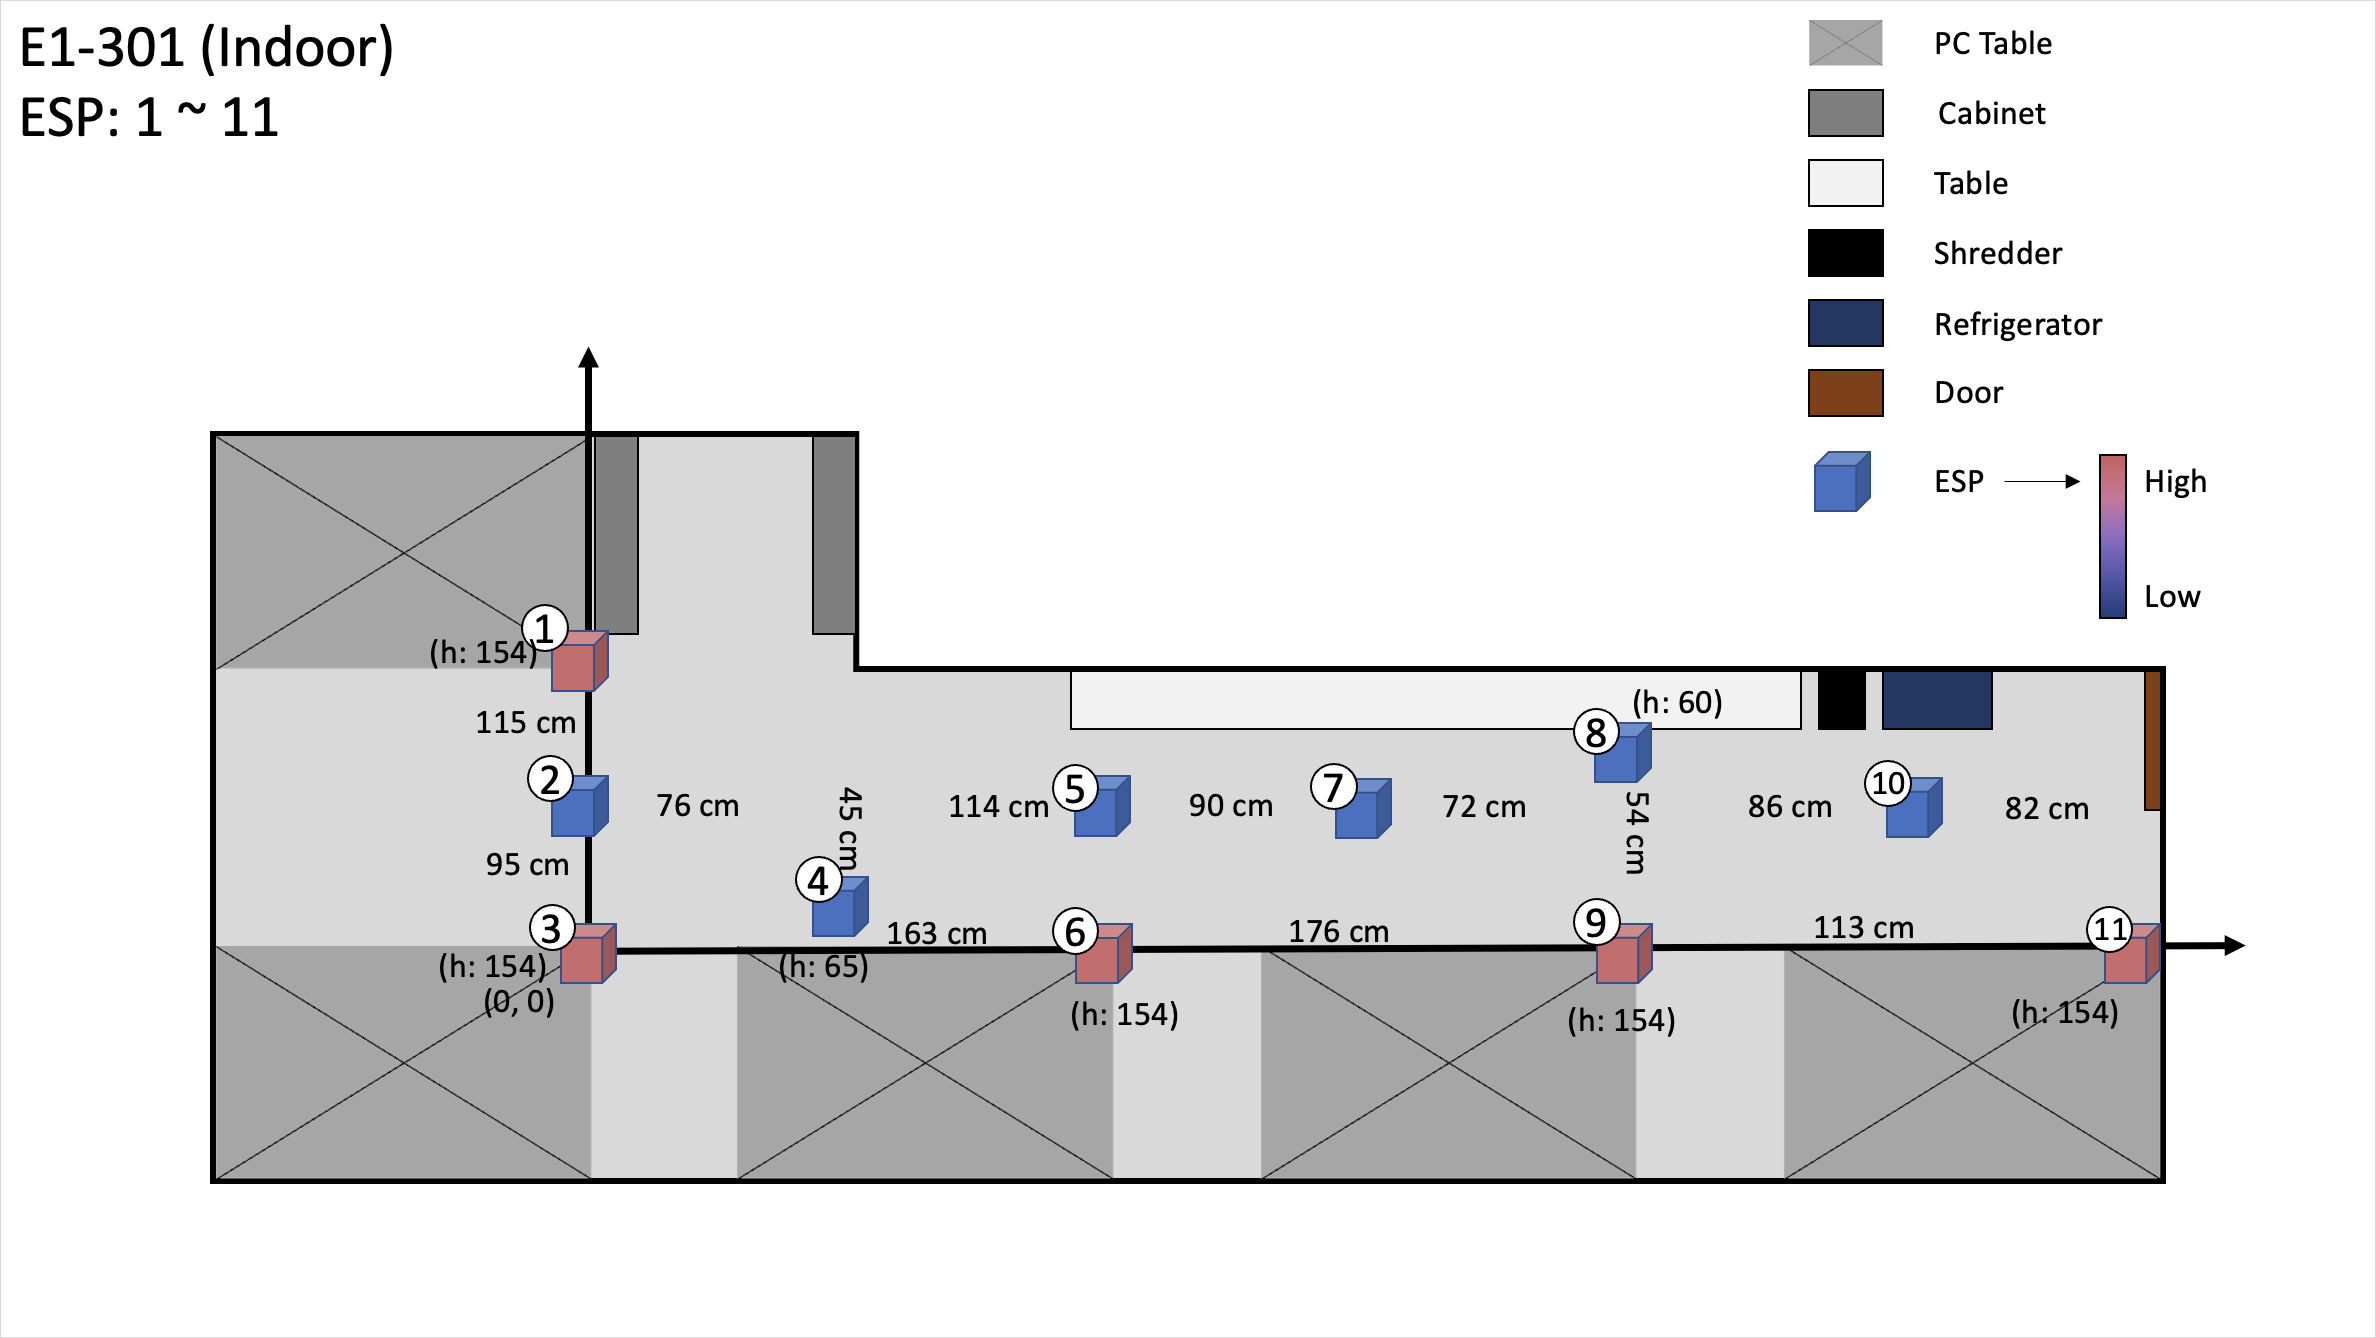

### Outdoor ENV
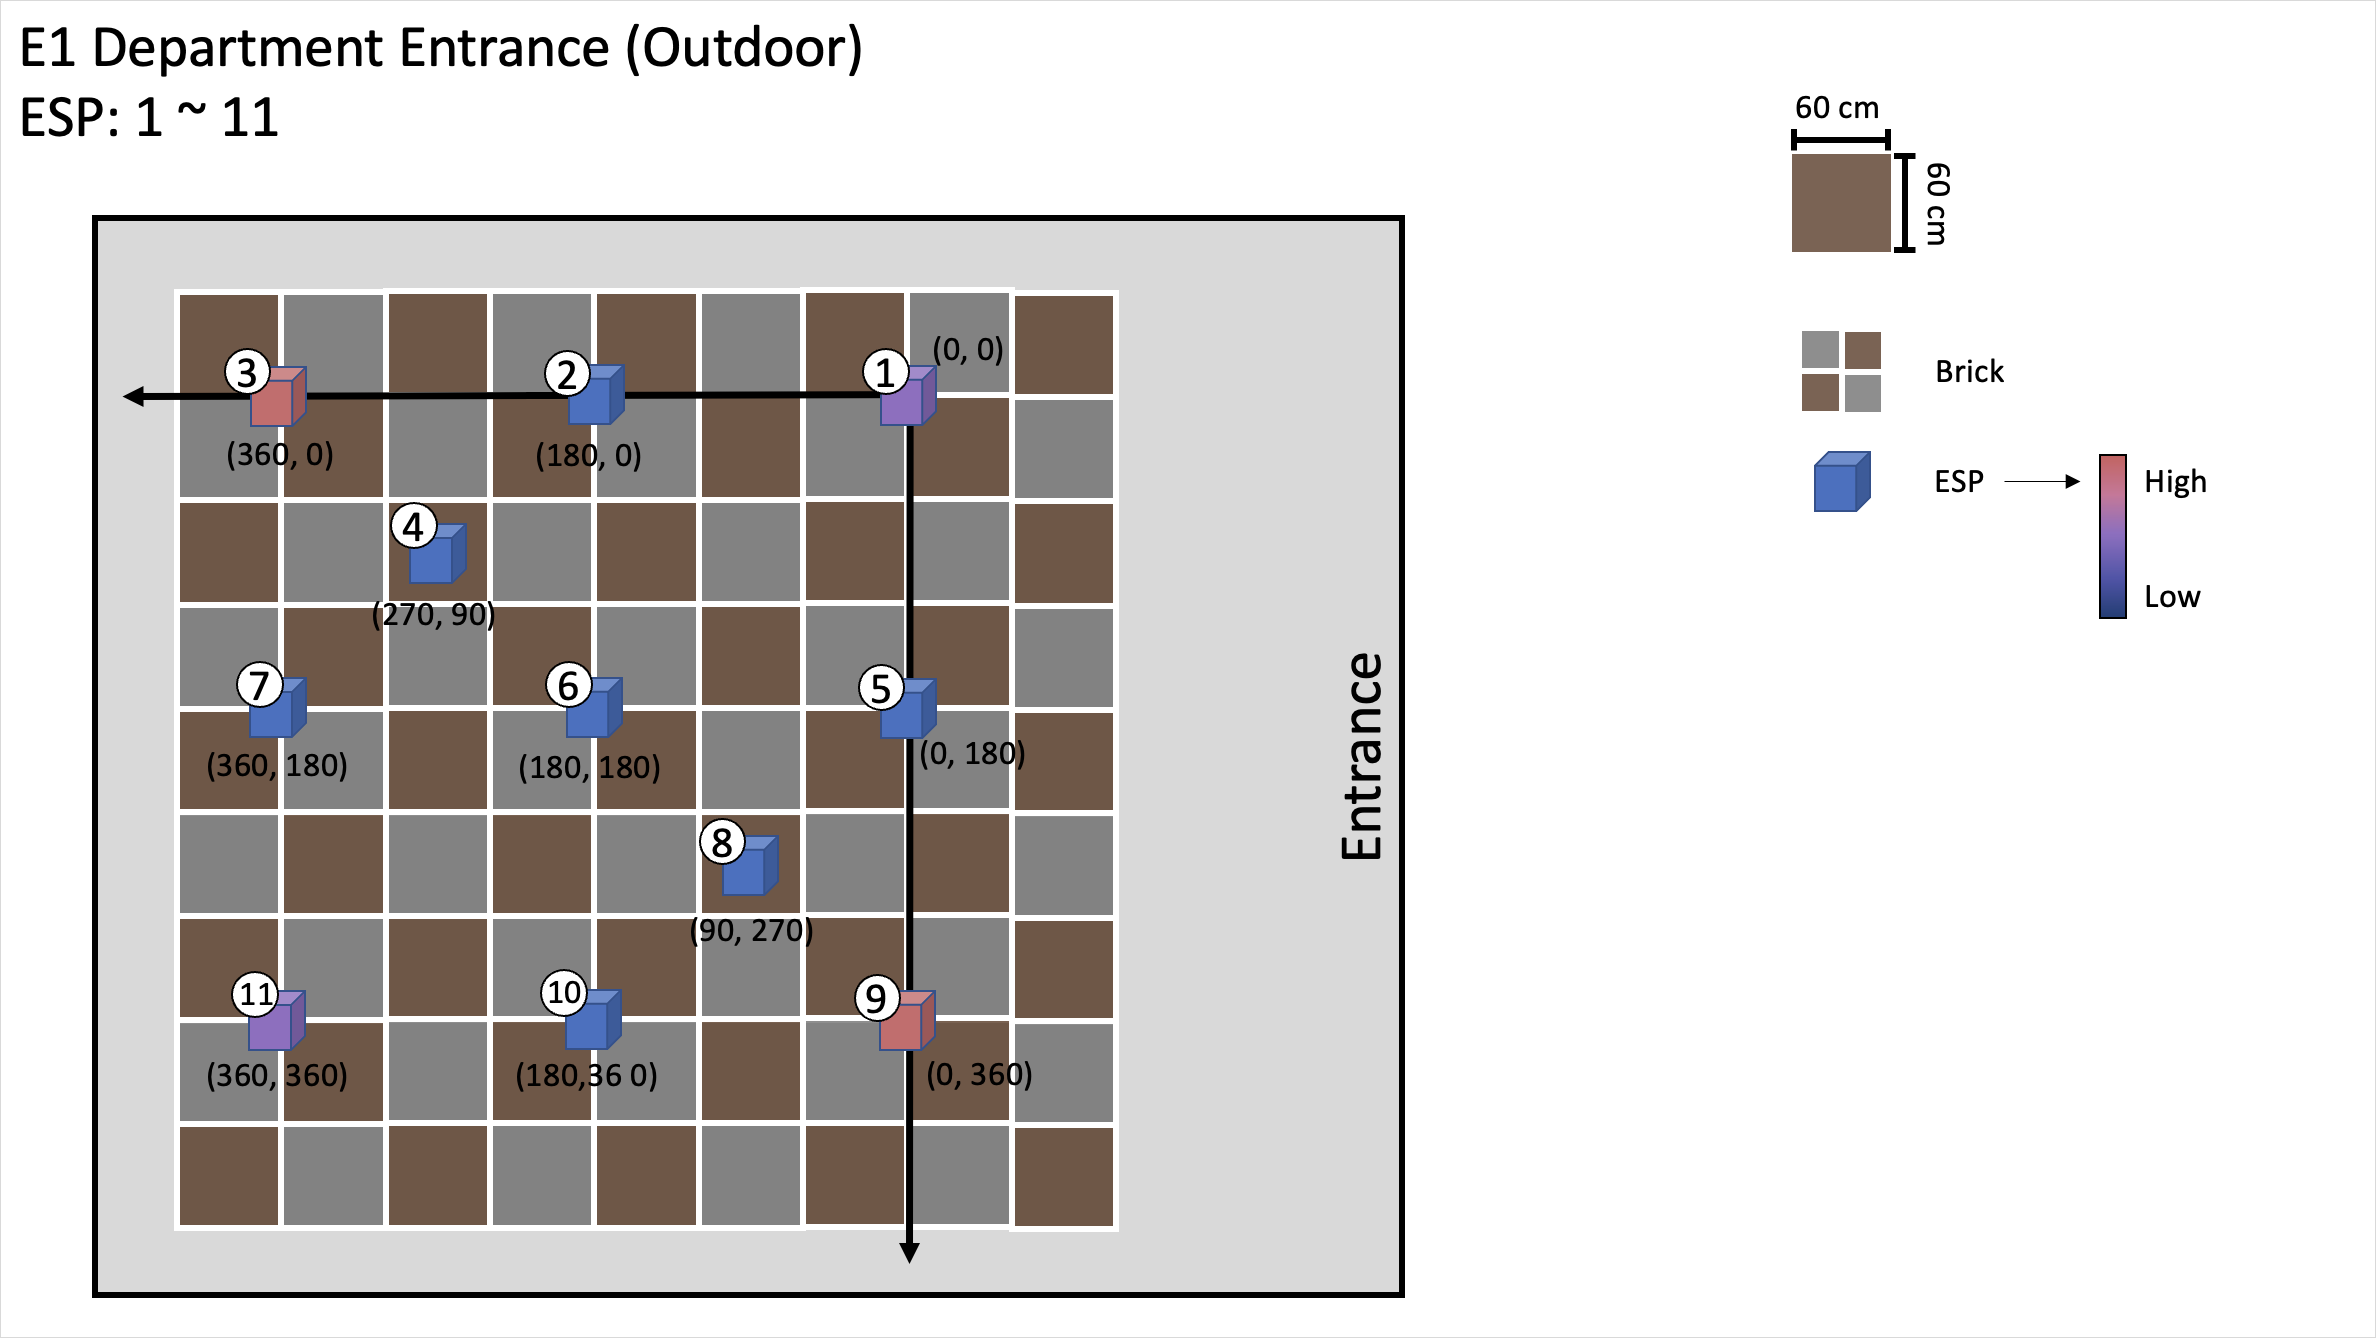

In [6]:
espPositions_cm

{'ESP01': [0, 210, 154],
 'ESP02': [0, 95, 28],
 'ESP03': [0, 0, 154],
 'ESP04': [76, 50, 65],
 'ESP05': [190, 95, 27],
 'ESP06': [163, 0, 154],
 'ESP07': [280, 95, 28],
 'ESP08': [352, 149, 60],
 'ESP09': [339, 0, 154],
 'ESP10': [438, 95, 23],
 'ESP11': [452, 0, 154]}

### Reference PL (For validating the value PL_0 = 40)

$ P_L(dBm) = -10\log_{10}{( \frac{\lambda^2}{(4\pi d_0)^2})} = +20\log_{10}{( \frac{4\pi d_0}{\lambda})}$

In [7]:
RSSDatas = {}
filePath = rootpath+"/datas/realRSSMeasurements"+rssFolder
for i in range(env.N):
  RSSDatas[ESPNames[i]] = {}
  for j in range(env.N):
    if i == j :
      continue
    with open(filePath+"/esp{}/RSS_{}_to_{}.csv".format(int(ESPNames[i][3:]),ESPNames[i],ESPNames[j]), "r") as _csv:
      csvReader = list(csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
      RSSDatas[ESPNames[i]][ESPNames[j]] = np.asarray(csvReader).T[0]
      # print(ESPNames[i],ESPNames[j],len(RSSDatas[ESPNames[i]][ESPNames[j]]))

In [8]:
import numpy as np, scipy.stats as st
import random
import matplotlib.pyplot as plt
shuffleRSSDatas = {}
for i in range(env.N):
  shuffleRSSDatas[ESPNames[i]] = {}
  for j in range(env.N):
    if i == j :
      continue
    a = list(RSSDatas[ESPNames[i]][ESPNames[j]])
    mean,std = np.mean(a),st.sem(a)
    random.shuffle(a)
    shuffleRSSDatas[ESPNames[i]][ESPNames[j]] = a 
    # plt.plot(a)
    # print(ESPNames[i],ESPNames[j],mean,std)

In [9]:
TargetSize = 200
WinD0wSizE = 1000
TargetRSSI = {}
for i in range(env.N):
  TargetRSSI[ESPNames[i]] = {}
  for j in range(env.N):
    if i == j :
      continue
    # print(shuffleRSSDatas[ESPNames[i]].keys())
    _shift = len(shuffleRSSDatas[ESPNames[i]][ESPNames[j]])//TargetSize
    a = shuffleRSSDatas[ESPNames[i]][ESPNames[j]]
    TargetRSSI[ESPNames[i]][ESPNames[j]] = [ np.mean(a[(iTarget*_shift):(iTarget*_shift+WinD0wSizE)]) for iTarget in range(TargetSize) ] 
# len(shuffleRSSDatas[ESPNames[0]][ESPNames[10]])
print(TargetRSSI)
print(len(TargetRSSI['ESP01']['ESP02']))

{'ESP01': {'ESP02': [-40.934, -40.936, -40.939, -40.947, -40.982, -40.998, -40.985, -40.958, -40.945, -40.902, -40.871, -40.885, -40.908, -40.909, -40.928, -40.942, -40.944, -40.94, -40.931, -40.937, -40.932, -40.922, -40.922, -40.934, -40.949, -40.942, -40.944, -40.944, -40.954, -40.958, -40.963, -40.965, -40.974, -40.966, -40.943, -40.967, -40.958, -40.977, -40.982, -40.979, -40.954, -40.974, -40.943, -40.932, -40.932, -40.944, -40.92, -40.926, -40.919, -40.929, -40.93, -40.939, -40.965, -40.985, -40.994, -41.001, -40.998, -40.973, -40.967, -40.96, -40.937, -40.936, -40.941, -40.932, -40.938, -40.956, -40.95, -40.943, -40.948, -40.948, -40.95, -40.958, -40.957, -40.955, -40.939, -40.924, -40.944, -40.937, -40.923, -40.916, -40.924, -40.911, -40.915, -40.93, -40.952, -40.961, -40.975, -40.988, -40.983, -40.985, -40.971, -40.954, -40.961, -40.986, -40.973, -40.992, -40.993, -40.978, -40.964, -40.969, -40.956, -40.955, -40.949, -40.919, -40.905, -40.903, -40.917, -40.93, -40.956, -40.97

RSS error > 0:
power + rss error

RSS error < 0:
ple - (rss error/2)

In [ ]:
# pathLossModel = PathLossModel()
# pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = 0)
# print("ENV SET: PLE: ", pathLossModel.ple)
# print("ENV SET: Tx power: ", env.UAV_TRANSMISSION_POWER)
# print()
# testI = "ESP01"
# testJ = "ESP02"
# print("Test: "+testI+" to "+testJ)

# realDist = np.linalg.norm(np.array(espPositions_cm[testI]) - np.array(espPositions_cm[testJ]))/100
# supposedRSS = pathLossModel.estimateRSS(env.UAV_TRANSMISSION_POWER, realDist)
# realRSS = np.mean(TargetRSSI[testI][testJ])
# estimatedDist = pathLossModel.estimateDistance(env.UAV_TRANSMISSION_POWER, realRSS)
# rssError = abs(realRSS - supposedRSS)
# print("supposedRSS = ", supposedRSS)
# print("realRSS = ", realRSS)
# print("rss error = ", realRSS - supposedRSS)
# print()
# print("realDist = ", realDist)
# print("estimatedDist = ", estimatedDist)

In [ ]:
# print("ENV SET: PLE: ", pathLossModel.ple)
# print("ENV SET: Tx power: ", env.UAV_TRANSMISSION_POWER)

# for testI in ESPNames:
#   for testJ in ESPNames:
#     if testI == testJ:
#       continue
#     print("Test: "+testI+" to "+testJ)
#     print("avg real RSS = ", np.mean(TargetRSSI[testI][testJ]))
#     pathLossModel = PathLossModel()
#     pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = 0)
#     vector = np.array(espPositions_cm[testI]) - np.array(espPositions_cm[testJ])
#     testDist = np.linalg.norm(vector)/100
#     print("{} --- distance: {:.3f} m --- {}".format(testI, testDist, testJ))
#     testRSS = pathLossModel.estimateRSS(env.UAV_TRANSMISSION_POWER, testDist)
#     print("Estimated RSS: {:.1f}".format(testRSS))
#     d = pathLossModel.estimateDistance(env.UAV_TRANSMISSION_POWER, np.mean(TargetRSSI[testI][testJ]))
#     print("Estimated Dist: {:.1f}".format(d))
#     print("Dist deviation: ", abs(d-testDist), " m")
#     print("=====================================================================")

In [ ]:
# suitablePower = []
# pathLossModel = PathLossModel()
# pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = 0)
# for testI in ESPNames:
#   _suitablePower = []
#   for testJ in ESPNames:
#     if testI == testJ:
#       _suitablePower.append(0)
#     else:
#       rssError = 10
#       power = env.UAV_TRANSMISSION_POWER
#       ple = pathLossModel.ple
#       while abs(rssError) > 0.01:
#         realDist = np.linalg.norm(np.array(espPositions_cm[testI]) - np.array(espPositions_cm[testJ]))/100
#         supposedRSS = pathLossModel.estimateRSS(power, realDist)
#         realRSS = np.mean(TargetRSSI[testI][testJ])
#         rssError = realRSS - supposedRSS
#         if abs(rssError) > 0:
#           power += rssError
#       _suitablePower.append(power)
#   suitablePower.append(_suitablePower)

# print(suitablePower)
# filePath = rootpath+"/datas/realRSSMeasurements"
# with open(filePath + "/suitablePower.pkl", "wb") as f:
#   pickle.dump(suitablePower, f)

In [ ]:
# with open(rootpath+"/datas/realRSSMeasurements/suitablePower.pkl", "rb") as f:
#   suitablePower = pickle.load(f)

# for testI in ESPNames:
#   for testJ in ESPNames:
#     if testI == testJ:
#       continue
#     print("Test: "+testI+" to "+testJ)
#     print("avg real RSS = ", np.mean(TargetRSSI[testI][testJ]))
#     pathLossModel = PathLossModel()
#     pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = 0)
#     vector = np.array(espPositions_cm[testI]) - np.array(espPositions_cm[testJ])
#     testDist = np.linalg.norm(vector)/100
#     print("{} --- distance: {:.3f} m --- {}".format(testI, testDist, testJ))
#     testRSS = pathLossModel.estimateRSS(suitablePower[int (testI.split("ESP")[1])-1][int (testJ.split("ESP")[1])-1], testDist)
#     print("Estimated RSS: {:.1f}".format(testRSS))
#     d = pathLossModel.estimateDistance(suitablePower[int (testI.split("ESP")[1])-1][int (testJ.split("ESP")[1])-1], np.mean(TargetRSSI[testI][testJ]))
#     print("Estimated Dist: {:.1f}".format(d))
#     print("Dist deviation: ", abs(d-testDist), " m")
#     print("=====================================================================")

### Coordinate from 'cm' to 'm'

In [10]:
espPositions = {}
for esp in espPositions_cm:
  espPositions[esp] = list (map(lambda x: x/100, espPositions_cm[esp]))

In [11]:
espPositions

{'ESP01': [0.0, 2.1, 1.54],
 'ESP02': [0.0, 0.95, 0.28],
 'ESP03': [0.0, 0.0, 1.54],
 'ESP04': [0.76, 0.5, 0.65],
 'ESP05': [1.9, 0.95, 0.27],
 'ESP06': [1.63, 0.0, 1.54],
 'ESP07': [2.8, 0.95, 0.28],
 'ESP08': [3.52, 1.49, 0.6],
 'ESP09': [3.39, 0.0, 1.54],
 'ESP10': [4.38, 0.95, 0.23],
 'ESP11': [4.52, 0.0, 1.54]}

### Generate UAVSamples

In [ ]:
from model.uav import UAV
import time
UAVsSamples = {}
for Samplei in range(env.SAMPLES):
  UAVs = {}
  for esp_i in espPositions:
    uav = UAV(int (esp_i.split("ESP")[1]), espPositions[esp_i], espPositions[esp_i])
    UAVs[esp_i] = uav
  UAVsSamples[Samplei] = UAVs

for Samplei in UAVsSamples:
  for esp_i in UAVsSamples[Samplei]:
    for esp_j in UAVsSamples[Samplei]:
      if not esp_i == esp_j:
        rssList = TargetRSSI[esp_i][esp_j]
        # print(len(rssList))
        uav = UAVsSamples[Samplei][esp_i]
        uav.collectRSS(int (esp_j.split("ESP")[1]), int (rssList[Samplei]))
        UAVsSamples[Samplei][esp_i] = uav

print(env.N, env.N_ngps)
for iSample in UAVsSamples:
  print(".", end='')
  uavIndexes_withoutGPS = np.random.choice(env.N, env.N_ngps, replace=False)
  # print(uavIndexes_withoutGPS)
  for iTarget in uavIndexes_withoutGPS:
    uav = UAVsSamples[iSample]["ESP{:02d}".format(iTarget+1)]
    uav.observedPosition = None

with open(savePath+"/UAVsSamples_100_{}.pkl".format(str (round(time.time() * 1000))), "wb") as f:
  pickle.dump(UAVsSamples, f)
print("\n Saved!")

11 4
........................................................................................................................................................................................................
 Saved!


### Load UAV Samples

In [12]:
with open(savePath+"/UAVsSamples_100.pkl", "rb") as f:
  UAVsSamples = pickle.load(f)

In [13]:
import csv
gpsDrifting = []
with open(rootpath+'/datas/realGPSMeasurements/anomal_gpsDrifting.csv', 'r') as f:
  rows = csv.reader(f)
  gpsDrifting = list (map(lambda row: float (row[0]), rows))

print(len(gpsDrifting))
sorted_gpsDrifting = sorted(gpsDrifting, reverse = True)[:env.SAMPLES]
print(len(sorted_gpsDrifting))

3145
200


### Do SD-SOCP Localization

In [ ]:
import sys
import traceback

MAXPICKFROM = 0
MAXPICKERROR = 2
for ipickError in np.arange(MAXPICKFROM,MAXPICKERROR+1,1):
  import pickle as dill
  file = open(savePath+"/V2_anomalyUAVs_pick"+str(ipickError)+"_300.npy","wb")
  file.close()
  file = open(savePath+"/V2_UAVsSamples_pick"+str(ipickError)+"_300.npy","wb")
  file.close()
  for j in range(env.N_ngps):
    file = open(savePath+"/V2_test_position{}_pickerror{}_300.csv".format(j,ipickError),"wb")
    file.close()

from multiprocessing import Manager, Process
def RunSDP(ipickError,UAVsSamples):
  result = {}
  for iSample, UAVsSample in UAVsSamples.items():
    print(iSample)
    _pathLossModel = PathLossModel()
    _pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = 0)
    try:
      result[iSample] = calculateSDP(combinationSet({0:UAVsSample}), {0:UAVsSample}, _pathLossModel)[0]
      for j in range(env.N_ngps):
        with open(savePath+"/V2_test_position{}_pickerror{}_300.csv".format(j,ipickError), "a") as _csv:
          csvWriter = csv.writer(_csv, delimiter=',')
          csvWriter.writerows(result[iSample][j])
    except Exception as e:
      error_class = e.__class__.__name__
      detail = e.args[0]
      cl, exc, tb = sys.exc_info()
      lastCallStack = traceback.extract_tb(tb)[-1]
      fileName = lastCallStack[0]
      lineNum = lastCallStack[1]
      funcName = lastCallStack[2]
      errMsg = "\nFile \"{}\", line {}, in {}: [{}] {}\n".format(fileName, lineNum, funcName, error_class, detail)
      print(errMsg)
    print()
    anomalyUAVs = []
    for iUAV, UAV in UAVsSample.items():
      if UAV.observedPosition != None and UAV.observedPosition != UAV.realPosition:
        anomalyUAVs.append(UAV.id)
    with open(savePath+"/V2_anomalyUAVs_pick"+str(ipickError)+"_300.npy", 'ab') as handle:
      dill.dump(anomalyUAVs, handle)
    with open(savePath+"/V2_UAVsSamples_pick"+str(ipickError)+"_300.npy", 'ab') as handle:
      dill.dump(UAVsSample, handle)

for ipickError in np.arange(MAXPICKFROM,MAXPICKERROR+1,1):
  # print("pickTime",pickTime)
  f = open(savePath+"/UAVsSamples_100.pkl", "rb")
  UAVsSamples = pickle.load(f)
  for iSample, UAVsSample in UAVsSamples.items():
    for pickTime in range(ipickError):
      uavList_gps = []
      for id, uav in UAVsSample.items():
        if not uav.observedPosition == None and uav.observedPosition == uav.realPosition:
          uavList_gps.append(id)
      pickedAnomalyIndex = np.random.choice(uavList_gps, 1, replace=False)[0]
      # print(pickedAnomalyIndex)
      originObservedPosition = UAVsSample[pickedAnomalyIndex].observedPosition
      shift = np.random.choice(sorted_gpsDrifting, 3, replace=False)
      anomalyObservedPosition = [originObservedPosition[0]+shift[0], originObservedPosition[1]+shift[1], originObservedPosition[2]+shift[2]]
      UAVsSample[pickedAnomalyIndex].observedPosition = anomalyObservedPosition

  # print(UAVsSamples)
  print("\nAnomaly: ", ipickError)
  RunSDP(ipickError,UAVsSamples)


Anomaly:  0
0
█████████████████████████████

1
█████████████████████████████

2
█████████████████████████████

3
█████████████████████████████

4
█████████████████████████████

5
█████████████████████████████

6
█████████████████████████████

7
█████████████████████████████

8
█████████████████████████████

9
█████████████████████████████

10
█████████████████████████████

11
█████████████████████████████

12
█████████████████████████████

13
█████████████████████████████

14
█████████████████████████████

15
█████████████████████████████

16
█████████████████████████████

17
█████████████████████████████

18
█████████████████████████████

19
█████████████████████████████

20
█████████████████████████████

21
█████████████████████████████

22
█████████████████████████████

23
█████████████████████████████

24
█████████████████████████████

25
█████████████████████████████

26
█████████████████████████████

27
█████████████████████████████

28
█████████████████████████████

29
████████

### Read Localization Result

In [ ]:
import csv
socpResultsDatas = []
# for j in range(0):
for j in range(env.N_ngps):
  with open(savePath+"/V2_test_position{}_pickerror1_300.csv".format(j), "r") as _csv:
    csvReader = list (csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
    socpResultsDatas.append(csvReader)

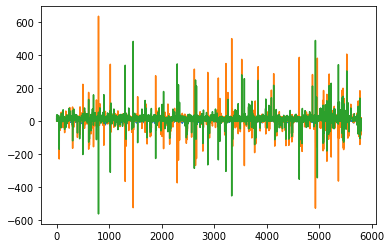

In [ ]:
import matplotlib.pyplot as plt
d = np.array(socpResultsDatas[2])
plt.plot(d)
# len(socpResultsDatas[1])

In [ ]:
np.array(socpResultsDatas).shape

(4, 5800, 3)

In [ ]:
rawDatas = []
ReadSampleSize = len(UAVsSamples)
groupSize =0
from scipy.special import comb, perm
for i in np.arange(env.DIMENSION+2,env.N_gps+1,1):
  groupSize += comb(env.N_gps,i)
groupSize = int(groupSize)
for i in range(env.N_ngps):
  temp = []
  for j in range(ReadSampleSize):
    temp.append(socpResultsDatas[i][j*groupSize : j*groupSize+groupSize])
  rawDatas.append(temp)

In [ ]:
shapeOfrawdatas = np.array(rawDatas).shape
shapeOfrawdatas

(4, 200, 29, 3)

In [ ]:
socpResultsData_np = np.asarray(socpResultsDatas).T
socpResultsData_np.sort()
shift = np.min(socpResultsData_np)
print(shift)

蛤尛 = []
shiftUAVSamples = {}
for iUAV in range(shapeOfrawdatas[0]):
  蛤尛.append([])
  for iSample in range(shapeOfrawdatas[1]):
    a = np.array(rawDatas[iUAV][iSample])
    蛤尛[iUAV].append(a)
for iSample in range(shapeOfrawdatas[1]):
  shiftUAVSamples[iSample] = UAVsSamples[iSample]
# print(蛤尛[0][1])
print(np.array(蛤尛).shape)
print(len(shiftUAVSamples))
with open(savePath+"/V2_shiftRawDatas.pkl", "wb") as f:
  pickle.dump(蛤尛, f)
with open(savePath+"/V2_shiftUAVSamples.pkl", "wb") as f:
  pickle.dump(shiftUAVSamples, f)

-564.5429267341549
(4, 200, 29, 3)
200


## MDS

In [ ]:
MAXPICKFROM = 0
MAXPICKERROR = 2
mdsSavePath = '/content/drive/Shareddrives/KW phase1 repo/datas/anomalyNewSDPResult/0906_real_indoor_MDS_10-26'
from sklearn.manifold import MDS
for ipickError in np.arange(MAXPICKFROM,MAXPICKERROR+1,1):
  import pickle as dill
  file = open(mdsSavePath+"/anomalyUAVs_pick"+str(ipickError)+"_100.npy","wb")
  file.close()
  file = open(mdsSavePath+"/UAVsSamples_pick"+str(ipickError)+"_100.npy","wb")
  file.close()
  for j in range(env.N_ngps):
    file = open(mdsSavePath+"/test_position{}_pickerror{}_100.csv".format(j,ipickError),"wb")
    file.close()
    # print(ipickError)
  
for ipickError in np.arange(MAXPICKFROM,MAXPICKERROR+1,1):
  f = open(mdsSavePath+"/UAVsSamples_100.pkl", "rb")
  UAVsSamples = pickle.load(f)
  print(UAVsSamples)
  for iSample, UAVSample in UAVsSamples.items():
    for pickTime in range(ipickError):
      # print("pickTime",pickTime)
      uavList_gps = []
      for id, uav in UAVSample.items():
        if not uav.observedPosition == None and uav.observedPosition == uav.realPosition:
          uavList_gps.append(id)
      pickedAnomalyIndex = np.random.choice(uavList_gps, 1, replace=False)[0]
      # print("pickedAnomalyIndex",pickedAnomalyIndex)
      originObservedPosition = UAVSample[pickedAnomalyIndex].observedPosition
      shift = np.random.choice(sorted_gpsDrifting, 3, replace=False)
      anomalyObservedPosition = [originObservedPosition[0]+shift[0], originObservedPosition[1]+shift[1], originObservedPosition[2]+shift[2]]
      UAVSample[pickedAnomalyIndex].observedPosition = anomalyObservedPosition
  for iSample, UAVSample in UAVsSamples.items():
    # print("Sample: ", iSample)
    print(".", end="")
    uavAnchorOfSegments = []
    uavTargetOfSegments = []
    uavAnchorOfSegmentsMDS = []
    uavTargetOfSegmentsMDS = []
    groupSet = combinationSet({0:UAVSample})[0]
    # print(groupSet)

    ## for GPS data
    for anchorSize, segments in groupSet.items():
      for segment in segments:
        uavAnchors = []
        for anchorID in segment:
          uavAnchors.append(UAVSample[anchorID].observedPosition)
        for i in range(env.N_gps-len(uavAnchors)):
          uavAnchors.append([0.0,0.0,0.0])
        uavAnchorOfSegments.append(uavAnchors)
    # print(np.array(uavAnchorOfSegments).shape)
    ## for RSS data
    for anchorSize, segments in groupSet.items():
      for segment in segments:
        uavTargets = [ [] for i in range(env.N_gps)]
        iAnchor = 0
        for anchorID in segment:
          for id, uav in UAVSample.items():
            if uav.observedPosition == None:
              rss = uav.searchRSSById(int(anchorID[3:]))
              uavTargets[iAnchor].append(rss)
          iAnchor += 1
        for i in range(env.N_gps-iAnchor):
          # print(iAnchor)
          for id, uav in UAVSample.items():
            if uav.observedPosition == None:
              rss = uav.searchRSSById(int(anchorID[3:]))
              uavTargets[iAnchor].append(0)
          iAnchor += 1
        # print(uavTargets)
        # print(np.array(uavTargets).shape)
        uavTargetOfSegments.append(uavTargets)
    # print(np.array(uavTargetOfSegments).shape)
    import numpy as np
    # from sklearn.decomposition import PCA
    for anchorGPS in uavAnchorOfSegments:
      mds = MDS(n_components=1)
      # print(np.array(anchorGPS).shape)
      # print(euclidean_distances(np.array(anchorGPS), squared=True))
      # anchorGPStransfer = mds.fit_transform(euclidean_distances(np.array(anchorGPS), squared=True))
      anchorGPStransfer = mds.fit_transform(anchorGPS)
      uavAnchorOfSegmentsMDS.append(anchorGPStransfer)
    # print(np.array(uavAnchorOfSegmentsMDS).shape)
    for anchorRSS in uavTargetOfSegments:
      # print(euclidean_distances(np.array(anchorRSS), squared=True))
      mds = MDS(n_components=1)
      # anchorRSStransfer = mds.fit_transform(euclidean_distances(np.array(anchorRSS), squared=True))
      anchorRSStransfer = mds.fit_transform(anchorRSS)
      uavTargetOfSegmentsMDS.append(anchorRSStransfer)
    # print(np.array(uavTargetOfSegmentsMDS).shape)
    uavAnchorOfSegmentsMDS = np.array(uavAnchorOfSegmentsMDS)
    uavTargetOfSegmentsMDS = np.array(uavTargetOfSegmentsMDS)
    MDSdata = np.append(uavAnchorOfSegmentsMDS, uavAnchorOfSegmentsMDS,axis=2)
    MDSdata = MDSdata.transpose((1,0,2))
    # print(np.array(MDSdata).shape)
    for j in range(env.N_ngps):
      with open(mdsSavePath+"/test_position{}_pickerror{}_100.csv".format(j,ipickError), "a") as _csv:
        csvWriter = csv.writer(_csv, delimiter=',')
        csvWriter.writerows(MDSdata[j])
    anomalyUAVs = []
    for iUAV, UAV in UAVSample.items():
      if UAV.observedPosition != None and UAV.observedPosition != UAV.realPosition:
        # print(UAV.observedPosition)
        # print(UAV.realPosition)
        anomalyUAVs.append(UAV.id)
    with open(mdsSavePath+"/anomalyUAVs_pick"+str(ipickError)+"_100.npy", 'ab') as handle:
      # print(anomalyUAVs)
      dill.dump(anomalyUAVs, handle)
    with open(mdsSavePath+"/UAVsSamples_pick"+str(ipickError)+"_100.npy", 'ab') as handle:
      dill.dump(UAVSample, handle)

{0: {'ESP01': <model.uav.UAV object at 0x7f5afa30afd0>, 'ESP02': <model.uav.UAV object at 0x7f5afa312910>, 'ESP03': <model.uav.UAV object at 0x7f5afa312b10>, 'ESP04': <model.uav.UAV object at 0x7f5afa312990>, 'ESP05': <model.uav.UAV object at 0x7f5afa312d10>, 'ESP06': <model.uav.UAV object at 0x7f5afa312950>, 'ESP07': <model.uav.UAV object at 0x7f5afa312b90>, 'ESP08': <model.uav.UAV object at 0x7f5afa312cd0>, 'ESP09': <model.uav.UAV object at 0x7f5afa312e50>, 'ESP10': <model.uav.UAV object at 0x7f5afa3129d0>, 'ESP11': <model.uav.UAV object at 0x7f5afa312f10>}, 1: {'ESP01': <model.uav.UAV object at 0x7f5afa312e10>, 'ESP02': <model.uav.UAV object at 0x7f5afa312a90>, 'ESP03': <model.uav.UAV object at 0x7f5afa312d50>, 'ESP04': <model.uav.UAV object at 0x7f5afa312c90>, 'ESP05': <model.uav.UAV object at 0x7f5afa312ed0>, 'ESP06': <model.uav.UAV object at 0x7f5afa312810>, 'ESP07': <model.uav.UAV object at 0x7f5afa312f50>, 'ESP08': <model.uav.UAV object at 0x7f5afa312790>, 'ESP09': <model.uav.U

## PCA

In [ ]:
import pickle as dill
pcaSavePath = '/content/drive/Shareddrives/KW phase1 repo/datas/anomalyNewSDPResult/0906_real_indoor_PCA_10-26'
MAXPICKFROM = 0
MAXPICKERROR = 2
for ipickError in np.arange(MAXPICKFROM,MAXPICKERROR+1,1):
  import pickle as dill
  file = open(pcaSavePath+"/anomalyUAVs_pick"+str(ipickError)+"_100.npy","wb")
  file.close()
  file = open(pcaSavePath+"/UAVsSamples_pick"+str(ipickError)+"_100.npy","wb")
  file.close()
  for j in range(env.N_ngps):
    file = open(pcaSavePath+"/test_position{}_pickerror{}_100.csv".format(j,ipickError),"wb")
    file.close()
    print(ipickError)
for ipickError in np.arange(MAXPICKFROM,MAXPICKERROR+1,1):
  with open(pcaSavePath+"/UAVsSamples_100.pkl", "rb") as f:
    UAVsSamples = pickle.load(f)
  # print(len(UAVsSamples[0]))
  # UAVsSamples = {0:UAVsSamples[0]}
  for iSample, UAVSample in UAVsSamples.items():
    for pickTime in range(ipickError):
      print("pickTime",pickTime)
      uavList_gps = []
      for id, uav in UAVSample.items():
        if not uav.observedPosition == None and uav.observedPosition == uav.realPosition:
          uavList_gps.append(id)
      pickedAnomalyIndex = np.random.choice(uavList_gps, 1, replace=False)[0]
      # print("pickedAnomalyIndex",pickedAnomalyIndex)
      originObservedPosition = UAVSample[pickedAnomalyIndex].observedPosition
      shift = np.random.choice(sorted_gpsDrifting, 3, replace=False)
      anomalyObservedPosition = [originObservedPosition[0]+shift[0], originObservedPosition[1]+shift[1], originObservedPosition[2]+shift[2]]
      UAVSample[pickedAnomalyIndex].observedPosition = anomalyObservedPosition
  for iSample, UAVSample in UAVsSamples.items():
    uavAnchorOfSegments = []
    uavTargetOfSegments = []
    uavAnchorOfSegmentsPCA = []
    uavTargetOfSegmentsPCA = []
    groupSet = combinationSet({0:UAVSample})[0]
    # print(groupSet)

    ## for GPS data
    for anchorSize, segments in groupSet.items():
      for segment in segments:
        uavAnchors = []
        for anchorID in segment:
          uavAnchors.append(UAVSample[anchorID].observedPosition)
        for i in range(env.N_gps-len(uavAnchors)):
          uavAnchors.append([0.0,0.0,0.0])
        uavAnchorOfSegments.append(uavAnchors)
    # print(np.array(uavAnchorOfSegments).shape)
    ## for RSS data
    for anchorSize, segments in groupSet.items():
      for segment in segments:
        uavTargets = [ [] for i in range(env.N_gps)]
        iAnchor = 0
        for anchorID in segment:
          for id, uav in UAVSample.items():
            if uav.observedPosition == None:
              rss = uav.searchRSSById(int(anchorID[3:]))
              uavTargets[iAnchor].append(rss)
          iAnchor += 1
        for i in range(env.N_gps-iAnchor):
          # print(iAnchor)
          for id, uav in UAVSample.items():
            if uav.observedPosition == None:
              rss = uav.searchRSSById(int(anchorID[3:]))
              uavTargets[iAnchor].append(0)
          iAnchor += 1
        # print(uavTargets)
        # print(np.array(uavTargets).shape)
        uavTargetOfSegments.append(uavTargets)
    # print(np.array(uavTargetOfSegments).shape)
    import numpy as np
    from sklearn.decomposition import PCA
    for anchorGPS in uavAnchorOfSegments:
      pca = PCA(n_components=1)
      anchorGPStransfer = pca.fit(anchorGPS).transform(anchorGPS)
      uavAnchorOfSegmentsPCA.append(anchorGPStransfer)
    # print(np.array(uavAnchorOfSegmentsPCA).shape)
    for anchorRSS in uavTargetOfSegments:
      pca = PCA(n_components=1)
      anchorRSStransfer = pca.fit(anchorRSS).transform(anchorRSS)
      uavTargetOfSegmentsPCA.append(anchorRSStransfer)
    # print(np.array(uavTargetOfSegmentsPCA).shape)
    uavAnchorOfSegmentsPCA = np.array(uavAnchorOfSegmentsPCA)
    uavTargetOfSegmentsPCA = np.array(uavTargetOfSegmentsPCA)
    PCAdata = np.append(uavAnchorOfSegmentsPCA, uavAnchorOfSegmentsPCA,axis=2)
    PCAdata = PCAdata.transpose((1,0,2))
    # print(np.array(PCAdata).shape)
    for j in range(env.N_ngps):
      with open(pcaSavePath+"/test_position{}_pickerror{}_100.csv".format(j,ipickError), "a") as _csv:
        csvWriter = csv.writer(_csv, delimiter=',')
        csvWriter.writerows(PCAdata[j])
    anomalyUAVs = []
    for iUAV, UAV in UAVSample.items():
      if UAV.observedPosition != None and UAV.observedPosition != UAV.realPosition:
        # print(UAV.observedPosition)
        # print(UAV.realPosition)
        anomalyUAVs.append(UAV.id)
    with open(pcaSavePath+"/anomalyUAVs_pick"+str(ipickError)+"_100.npy", 'ab') as handle:
      dill.dump(anomalyUAVs, handle)
    with open(pcaSavePath+"/UAVsSamples_pick"+str(ipickError)+"_100.npy", 'ab') as handle:
      dill.dump(UAVSample, handle)
  

0
0
0
0
1
1
1
1
2
2
2
2
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime 0
pickTime

## t-SNE

In [14]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [15]:
import pickle as dill
from sklearn.manifold import TSNE
tSNESavePath = '/content/drive/Shareddrives/KW phase1 repo/datas/anomalyNewSDPResult/0419_real_indoor_tSNE_10-26'
MAXPICKFROM = 0
MAXPICKERROR = 2
for ipickError in np.arange(MAXPICKFROM,MAXPICKERROR+1,1):
  print("Prepare files")
  import pickle as dill
  file = open(tSNESavePath+"/anomalyUAVs_pick"+str(ipickError)+"_100.npy","wb")
  file.close()
  file = open(tSNESavePath+"/UAVsSamples_pick"+str(ipickError)+"_100.npy","wb")
  file.close()
  for j in range(env.N_ngps):
    file = open(tSNESavePath+"/test_position{}_pickerror{}_100.csv".format(j,ipickError),"wb")
    file.close()
for ipickError in np.arange(MAXPICKFROM,MAXPICKERROR+1,1):
  print("ipickError:", ipickError)

  with open(savePath+"/UAVsSamples_100.pkl", "rb") as f:
    UAVsSamples = pickle.load(f)

  for iSample, UAVSample in UAVsSamples.items():
    for pickTime in range(ipickError):
      uavList_gps = []
      for id, uav in UAVSample.items():
        if not uav.observedPosition == None and uav.observedPosition == uav.realPosition:
          uavList_gps.append(id)
      pickedAnomalyIndex = np.random.choice(uavList_gps, 1, replace=False)[0]
      originObservedPosition = UAVSample[pickedAnomalyIndex].observedPosition
      shift = np.random.choice(sorted_gpsDrifting, 3, replace=False)
      anomalyObservedPosition = [originObservedPosition[0]+shift[0], originObservedPosition[1]+shift[1], originObservedPosition[2]+shift[2]]
      UAVSample[pickedAnomalyIndex].observedPosition = anomalyObservedPosition
  
  for iSample, UAVSample in UAVsSamples.items():
    uavAnchorOfSegments = []
    uavTargetOfSegments = []
    uavAnchorOfSegmentsTSNE = []
    uavTargetOfSegmentsTSNE = []
    groupSet = combinationSet({0:UAVSample})[0]

    ## for GPS data
    for anchorSize, segments in groupSet.items():
      for segment in segments:
        uavAnchors = []
        for anchorID in segment:
          uavAnchors.append(UAVSample[anchorID].observedPosition)
        for i in range(env.N_gps-len(uavAnchors)):
          uavAnchors.append([0.0,0.0,0.0])
        uavAnchorOfSegments.append(uavAnchors)

    ## for RSS data
    for anchorSize, segments in groupSet.items():
      for segment in segments:
        uavTargets = [ [] for i in range(env.N_gps)]
        iAnchor = 0
        for anchorID in segment:
          for id, uav in UAVSample.items():
            if uav.observedPosition == None:
              rss = uav.searchRSSById(int(anchorID[3:]))
              uavTargets[iAnchor].append(rss)
          iAnchor += 1
        for i in range(env.N_gps-iAnchor):
          for id, uav in UAVSample.items():
            if uav.observedPosition == None:
              rss = uav.searchRSSById(int(anchorID[3:]))
              uavTargets[iAnchor].append(0)
          iAnchor += 1

        uavTargetOfSegments.append(uavTargets)

    import numpy as np
    from sklearn.decomposition import PCA
    for anchorGPS in uavAnchorOfSegments:
      tsne = TSNE(n_components=1, random_state=1)
      anchorGPStransfer = tsne.fit_transform(np.array(anchorGPS))
      uavAnchorOfSegmentsTSNE.append(anchorGPStransfer)

    for anchorRSS in uavTargetOfSegments:

      tsne = TSNE(n_components=1, random_state=1)
      anchorRSStransfer = tsne.fit_transform(np.array(anchorRSS))
      uavTargetOfSegmentsTSNE.append(anchorRSStransfer)

    uavAnchorOfSegmentsTSNE = np.array(uavAnchorOfSegmentsTSNE)
    uavTargetOfSegmentsTSNE = np.array(uavTargetOfSegmentsTSNE)
    TSNEdata = np.append(uavAnchorOfSegmentsTSNE, uavAnchorOfSegmentsTSNE,axis=2)
    TSNEdata = TSNEdata.transpose((1,0,2))

    for j in range(env.N_ngps):
      with open(tSNESavePath+"/test_position{}_pickerror{}_100.csv".format(j,ipickError), "a") as _csv:
        csvWriter = csv.writer(_csv, delimiter=',')
        csvWriter.writerows(TSNEdata[j])
    anomalyUAVs = []
    for iUAV, UAV in UAVSample.items():
      if UAV.observedPosition != None and UAV.observedPosition != UAV.realPosition:
        anomalyUAVs.append(UAV.id)
    with open(tSNESavePath+"/anomalyUAVs_pick"+str(ipickError)+"_100.npy", 'ab') as handle:
      dill.dump(anomalyUAVs, handle)
    with open(tSNESavePath+"/UAVsSamples_pick"+str(ipickError)+"_100.npy", 'ab') as handle:
      dill.dump(UAVSample, handle)
  

Prepare files
0
0
0
0
Prepare files
1
1
1
1
Prepare files
2
2
2
2
ipickError: 0
ipickError: 1
ipickError: 2


## SDP

In [ ]:
from model.uav import UAV, setUAVEnv
from model.pureSDP import calculateSDP, setSDPEnv
from model.pathlossmodel import PathLossModel, NoiseMaker, setPathLossModelEnv

from service.distributeuavs import createUAVsSamples,setDistributeUavsEnv , TestEnv
from service.measurerss import measureRSS, setMeasuerRssEnv
from service.combinationset import combinationSet , setCombinationSetEnv
from multiprocessing import Pool

setDistributeUavsEnv("sdp_realRSS")
TestEnv()
setCombinationSetEnv("sdp_realRSS")
setPathLossModelEnv("sdp_realRSS")
setMeasuerRssEnv("sdp_realRSS")
setUAVEnv("sdp_realRSS")
setSDPEnv("sdp_realRSS")

envName sdp_realRSS
11


In [ ]:
import pickle as dill
sdpSavePath = '/content/drive/Shareddrives/KW phase1 repo/datas/anomalyNewSDPResult/0906_real_indoor_SDP_10-26'
MAXPICKFROM = 0
MAXPICKERROR = 2

for ipickError in np.arange(0,MAXPICKERROR+1,1):
  import pickle as dill
  file = open(sdpSavePath+"/anomalyUAVs_pick"+str(ipickError)+"_100.npy","wb")
  file.close()
  file = open(sdpSavePath+"/UAVsSamples_pick"+str(ipickError)+"_100.npy","wb")
  file.close()
  for j in range(env.N_ngps):
    file = open(sdpSavePath+"/test_position{}_pickerror{}_100.csv".format(j,ipickError),"wb")
    file.close()
    print(ipickError)

def RunSDP(deviation,ipickError,UAVsSamples):
  result = {}
  for iSample, UAVsSample in UAVsSamples.items():
    _pathLossModel = PathLossModel()
    _pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = 0)
    print(iSample)
    result[iSample] = calculateSDP(combinationSet({0:UAVsSample}), {0:UAVsSample}, _pathLossModel)[0]
    for j in range(env.N_ngps):
      with open(sdpSavePath+"/test_position{}_pickerror{}_100.csv".format(j,ipickError), "a") as _csv:
        csvWriter = csv.writer(_csv, delimiter=',')
        csvWriter.writerows(result[iSample][j])
    print()
    anomalyUAVs = []
    for iUAV, UAV in UAVsSample.items():
      if UAV.observedPosition != None and UAV.observedPosition != UAV.realPosition:
        anomalyUAVs.append(UAV.id)
    with open(sdpSavePath+"/anomalyUAVs_pick"+str(ipickError)+"_100.npy", 'ab') as handle:
      dill.dump(anomalyUAVs, handle)
    with open(sdpSavePath+"/UAVsSamples_pick"+str(ipickError)+"_100.npy", 'ab') as handle:
      dill.dump(UAVsSample, handle)

from multiprocessing import Manager, Process
for ipickError in np.arange(0,MAXPICKERROR+1,1):
  _pathLossModel = PathLossModel()
  _pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = 0)
  with open(sdpSavePath+"/UAVsSamples_100.pkl", "rb") as f:
    UAVsSamples = pickle.load(f)
  for iSample, UAVSample in UAVsSamples.items():
    for pickTime in range(ipickError):
      uavList_gps = []
      for id, uav in UAVSample.items():
        if not uav.observedPosition == None and uav.observedPosition == uav.realPosition:
          uavList_gps.append(id)
      pickedAnomalyIndex = np.random.choice(uavList_gps, 1, replace=False)[0]
      originObservedPosition = UAVSample[pickedAnomalyIndex].observedPosition
      shift = np.random.choice(sorted_gpsDrifting, 3, replace=False)
      anomalyObservedPosition = [originObservedPosition[0]+shift[0], originObservedPosition[1]+shift[1], originObservedPosition[2]+shift[2]]
      UAVSample[pickedAnomalyIndex].observedPosition = anomalyObservedPosition
  
  print("sub")
  p = Process(target=RunSDP, args=(0,ipickError,UAVsSamples))
  p.Daemon = True
  p.start()

for ipickError in np.arange(0,MAXPICKERROR+1,1):
  p.join()

0
0
0
0
1
1
1
1
2
2
2
2
sub
0
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.N 11
sub
0
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.N 11
sub
0
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.N 11
....................................................................................

1
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.N 11
.

1
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.N 11
......

1
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.N 11
.................................................................................

2
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.N 11
.

2
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.N 11
.
.
2
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.N 11
...................................................................................

3
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.N 11
..

3
[calculateSDP] envName:  sdp_realRSS
[calculateSDP] env.